In [1]:
# Scientific computing and data manipulation
import math
import time
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp

# Visualization
import matplotlib.pyplot as plt

# Machine learning and deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, LeaveOneOut

# Hyperparameter optimization
import optuna

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EarlyStopping function

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            #self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        #if self.verbose:
        #    self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

In [4]:
#import random

# To fix the random seed
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)
#random.seed(seed)

# Ensure deterministic behavior in PyTorch
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# DEFINE PARAMETERS

In [5]:
# define constant parameters

R = (6.4*10e-3)/2 # Tubular radius, units: m
qp_480 = 1.3 * 10e-4 * 60 # Photon flux, units: moles photons · m-2 · min-1
Vr = 4.78 * 10e-6# Reactor volume, units: m3
CB = 0.4 # Concentartion of reactant B, units: M

# Calculate photon flux at different power ratings

# 240 W
qp_240 = qp_480*240/480

#120 W
qp_120 = qp_480*120/480

In [6]:
# Experimentally measured parameters

phi_n = 0.07508614 # Quantum yield, units: mole/Einstien
k1 = 0.01953897 # rate constant for formation of species C
k2 = 0.11706072 # rate constant for formation of species E

# Regressed parameters

mpc = 94.6*0.02*(1/1000) # photon absorption by photocatalyst
ka =  324.7*(1/1000) # Napierian molar absorption coefficient of specis A, units: m2/mol
kc = 345.5*(1/1000) # Napierian molar absorption coefficient of specis C, units: m2/mol 

# LOAD DATA

In [7]:
Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0

Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


In [8]:
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (9, 36, 5)


In [9]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, 36, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, 36, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, 36, 1)
RNN_output = np.concatenate((Y1_output, Y2_output, Y3_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (9, 36, 3)


In [10]:
RNN_physics_input_temp = RNN_input
RNN_physics_output = RNN_output

In [11]:
# split into train and test sets
x_train = RNN_input[:7,:,:]
x_test  = RNN_input[7:,:,:]

y_train = RNN_output[:7,:,:]
y_test =  RNN_output[7:,:,:]

In [12]:
# Normalization

scaler_X = preprocessing.StandardScaler().fit(x_train.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 3))

print(scaler_X.mean_)
print(scaler_X.var_)
print(scaler_y.mean_)
print(scaler_y.var_)

x_train = scaler_X.transform(x_train.reshape(-1, 5)).reshape(-1,36, 5)
x_test = scaler_X.transform(x_test.reshape(-1, 5)).reshape(-1,36, 5)
y_train = scaler_y.transform(y_train.reshape(-1,3)).reshape(-1,36, 3)
y_test = scaler_y.transform(y_test.reshape(-1,3)).reshape(-1,36, 3)

mean_y = torch.from_numpy(scaler_y.mean_).float()
std_y = torch.from_numpy(np.sqrt(scaler_y.var_)).float()

[2.71428571e-01 3.08571429e+02 1.00000000e+00 0.00000000e+00
 0.00000000e+00]
[4.89795918e-03 2.40979592e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.27897316 0.70880471 0.01222213]
[2.25483977e-02 2.15162303e-02 1.75404646e-05]


In [13]:
############################# Split Train, Test, and Validation dataset ##################################

#X_train, x_test, Y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=42)

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train shape is {x_train.shape}, X_test shape is {x_test.shape}")
print(f"y_train shape is {y_train.shape}, y_test shape is {y_test.shape}")

X_train shape is (7, 36, 5), X_test shape is (2, 36, 5)
y_train shape is (7, 36, 3), y_test shape is (2, 36, 3)


# TRANSFORM DATA FOR TRAINING

In [14]:
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()

In [15]:
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
torch.save(mean_y,'mean_y.pt')
torch.save(std_y,'std_y.pt')
np.save('mean_X.npy',scaler_X.mean_)
np.save('std_X.npy',np.sqrt(scaler_X.var_))

mean_X = scaler_X.mean_
std_X = np.sqrt(scaler_X.var_)

In [17]:
dataset_physics_test = TensorDataset(x_test, y_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

# DEFINING RNN

In [18]:
class RNN(nn.Module):
    "Defines a RNN network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS
        
        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN[0], 
                                batch_first=True)
            
            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i], 
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )
            
            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)
            
            self.list_flag = True
            
        else:
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)
            
            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
            
            self.list_flag = False                                             
        
    def forward(self, x):
        x, _ = self.rnn(x)
        
        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)
                
        x = self.output_layer(x)
        return x

# LTC MODEL

In [19]:
from ncps.wirings import AutoNCP
from ncps.torch import LTC, CfC

In [20]:
def train_model_piltc(model, patience, n_epochs, lr):

    train_losses, valid_losses = [], []
    avg_train_losses, avg_valid_losses = [], []
    y_scaled_error = []
 
    optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=1e-5) # Adam optimizer
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch[0].to(device), y_batch[0].to(device)
            optimizer.zero_grad()

            NN_outputd = model(x_batch)
            NN_outputd = NN_outputd[0]
            loss1 = torch.mean((NN_outputd - y_batch) ** 2)
            
            loss = loss1
            loss.backward()
            optimizer.step()
            
            # record training loss
            train_losses.append(loss.item())

        # Validation
        model.eval()
        for x_valbatch, y_valbatch in val_loader:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            NN_outputv = model(x_valbatch)
            NN_outputv = NN_outputv[0]
            loss = torch.mean((NN_outputv - y_valbatch) ** 2)

            valid_losses.append(loss.item())
        
        # Logging
        train_loss = np.mean(train_losses)
        valid_loss = np.mean(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f"[{epoch}/{n_epochs}] train_loss: {train_loss:.5f} valid_loss: {valid_loss:.5f}")

        train_losses, valid_losses = [], []
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Evaluate best model on validation set once
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()

    final_predictions = []
    final_targets = []

    with torch.no_grad():
        for x_valbatch, y_valbatch in dataloader_physics_test:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            output = model(x_valbatch)
            output = output[0]

            preds = scaler_y.inverse_transform(output.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)
            targets = scaler_y.inverse_transform(y_valbatch.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)

            # Compute scaled loss
            c1 = np.sum(np.abs(preds[-1, :, 0] - targets[-1, :, 0]))
            c2 = np.sum(np.abs(preds[-1, :, 1] - targets[-1, :, 1]))
            c3 = np.sum(np.abs(preds[-1, :, 2] - targets[-1, :, 2]))
            scaled_loss = (3.377069851 * c1 + 1.443964636 * c2 + 88.12458286 * c3) / 100

            y_scaled_error.append(scaled_loss)

            final_predictions.append(preds)
            final_targets.append(targets)

    final_predictions = np.concatenate(final_predictions, axis=0)
    final_targets = np.concatenate(final_targets, axis=0)

    return model, avg_train_losses, avg_valid_losses, np.mean(avg_valid_losses), y_scaled_error, final_predictions, final_targets

In [21]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

# create loocv procedure
cv = LeaveOneOut()
batch_size = 32
k = 7

In [22]:
y_glob = []  # Will be a list of lists: shape (n_folds, n_repeats_per_fold)
sc_y_glob = []

all_val_preds = []  # list of length n_folds, each item is (5, n_samples, 36, 3)
val_targets = None


for fold, (train_idx_A, val_idx_A) in enumerate(cv.split(x_train)):
    print(f"  Fold {fold + 1}/{k}")

    # Create TensorDatasets and DataLoaders
    train_datasetA = TensorDataset(x_train[train_idx_A], y_train[train_idx_A])
    val_datasetA = TensorDataset(x_train[val_idx_A], y_train[val_idx_A])
    train_loader = DataLoader(train_datasetA, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_datasetA, batch_size=batch_size, shuffle=False)

    fold_errors = []
    sc_fold_errors = []

    for i in range(5):  # Repeat training to observe variability
        
        out_features = 3
        in_features = 5
        wiring = AutoNCP(64, out_features)  # 16 units, 1 motor neuron
        piltc_model1 = LTC(in_features, wiring, batch_first=True)

        print(f"  Training {i+1}/5 for Fold {fold+1}")
        #print(model_PINN)

        n_epochs = 100
        patience = 100
        lr = 0.01

        model_PINN, train_loss, valid_loss, test_error, mean_scaled, predictions, targets = train_model_piltc(
            piltc_model1, patience, n_epochs, lr)

        fold_errors.append(test_error)
        sc_fold_errors.append(mean_scaled)
        
        if i == 0:
            val_preds_fold = [predictions]
        else:
            val_preds_fold.append(predictions)

    y_glob.append(fold_errors)
    sc_y_glob.append(sc_fold_errors)
    
    val_preds_fold = np.stack(val_preds_fold, axis=0)  # shape: (5, n_samples, 36, 3)
    all_val_preds.append(val_preds_fold)

    if fold == 0:  # Only store ground truth once
        val_targets = targets

# Convert to NumPy array for easier processing
y_glob = np.array(y_glob)  # shape: (n_folds, 5)
sc_y_glob = np.array(sc_y_glob)  # shape: (n_folds, 5)

  Fold 1/7
  Training 1/5 for Fold 1
[1/100] train_loss: 0.76774 valid_loss: 2.20640
[2/100] train_loss: 0.91315 valid_loss: 2.12555
[3/100] train_loss: 0.75999 valid_loss: 2.02046
[4/100] train_loss: 0.76766 valid_loss: 1.96089
[5/100] train_loss: 0.87358 valid_loss: 1.95532
[6/100] train_loss: 0.73123 valid_loss: 1.93363
[7/100] train_loss: 1.28394 valid_loss: 1.98092
[8/100] train_loss: 0.64405 valid_loss: 2.01920
[9/100] train_loss: 1.14666 valid_loss: 2.09445
[10/100] train_loss: 1.06159 valid_loss: 2.19704
[11/100] train_loss: 0.65909 valid_loss: 2.27092
[12/100] train_loss: 0.90081 valid_loss: 2.36761
[13/100] train_loss: 0.80105 valid_loss: 2.42779
[14/100] train_loss: 0.81757 valid_loss: 2.45417
[15/100] train_loss: 0.76155 valid_loss: 2.47276
[16/100] train_loss: 0.82570 valid_loss: 2.46091
[17/100] train_loss: 0.81729 valid_loss: 2.42345
[18/100] train_loss: 0.80032 valid_loss: 2.36522
[19/100] train_loss: 0.77978 valid_loss: 2.29247
[20/100] train_loss: 0.76925 valid_loss: 

In [23]:
print(y_glob.shape)
print(sc_y_glob.shape)

(7, 5)
(7, 5, 2)



=== Summary for Output 1 ===
Per-Fold Means: [0.15074063 0.12957384 0.12245871 0.1359968  0.1353647  0.12482126
 0.11825886]
Per-Fold Std Devs: [0.02102995 0.01176047 0.02470715 0.01781773 0.00354801 0.02462124
 0.0068838 ]
Overall Mean: 0.1310, Overall Std: 0.0203


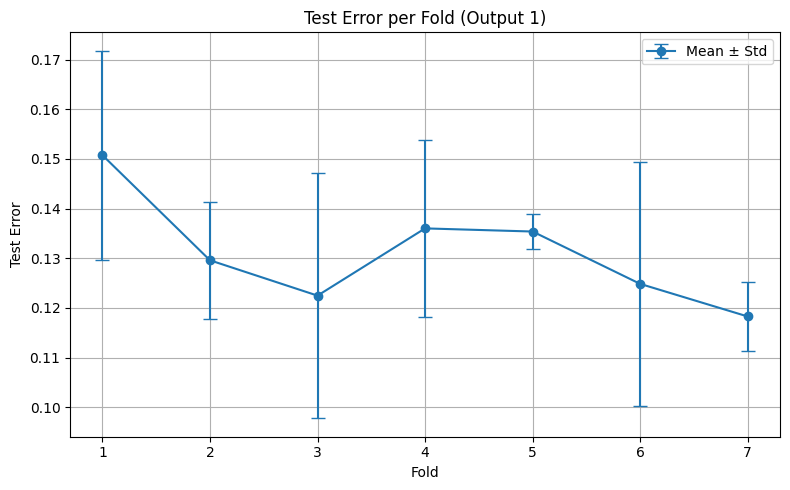


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.134344  0.129323  0.133558  0.125995  0.131934   0.131031  0.015767
std    0.015734  0.020236  0.025079  0.009710  0.031125   0.010872  0.008510
min    0.123189  0.098016  0.106946  0.112192  0.091818   0.118259  0.003548
25%    0.124417  0.114658  0.113679  0.119308  0.109455   0.123640  0.009322
50%    0.128064  0.136218  0.126751  0.127112  0.133388   0.129574  0.017818
75%    0.136598  0.146390  0.153734  0.131716  0.149039   0.135681  0.022826
max    0.167124  0.148930  0.166384  0.140612  0.181340   0.150741  0.024707

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.150741  0.021030
1   0.129574  0.011760
2   0.122459  0.024707
3   0.135997  0.017818
4   0.135365  0.003548
5   0.124821  0.024621
6   0.118259  0.006884

Per-fold Summary (across runs):
         Fold_1    F

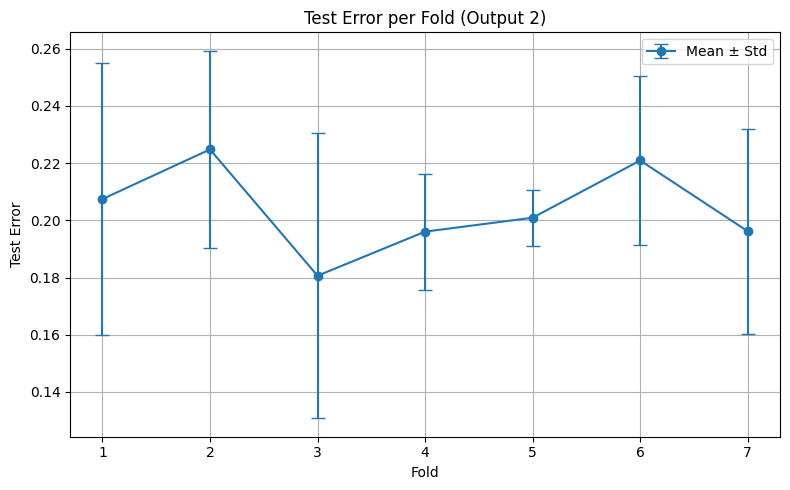


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.231699  0.206547  0.190234  0.193703  0.196981   0.203833  0.032462
std    0.019404  0.047320  0.029203  0.040059  0.044217   0.015323  0.014226
min    0.206027  0.131786  0.148625  0.139653  0.140698   0.180626  0.009767
25%    0.220445  0.190242  0.173685  0.170989  0.169659   0.196108  0.024923
50%    0.233233  0.209322  0.184340  0.190160  0.205593   0.200903  0.034498
75%    0.241157  0.218138  0.206832  0.217674  0.208187   0.214161  0.041646
max    0.259430  0.287962  0.237640  0.248781  0.276886   0.224765  0.049834

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.207419  0.047466
1   0.224765  0.034498
2   0.180626  0.049834
3   0.196033  0.020272
4   0.200903  0.009767
5   0.220902  0.029574
6   0.196182  0.035825

Per-fold Summary (across runs):
         Fold_1    F

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume sc_y_glob shape is (7, 5, 2) => (folds, runs, outputs)
n_outputs = sc_y_glob.shape[2]

for i in range(n_outputs):
    print(f"\n=== Summary for Output {i+1} ===")
    
    data_i = sc_y_glob[:, :, i]  # shape: (7, 5)
    
    fold_means = np.mean(data_i, axis=1)
    fold_stds = np.std(data_i, axis=1)

    overall_mean = np.mean(data_i)
    overall_std = np.std(data_i)

    # Print summary
    print("Per-Fold Means:", fold_means)
    print("Per-Fold Std Devs:", fold_stds)
    print(f"Overall Mean: {overall_mean:.4f}, Overall Std: {overall_std:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.errorbar(range(1, len(fold_means)+1), fold_means, yerr=fold_stds, fmt='o-', capsize=5, label='Mean ± Std')
    plt.title(f'Test Error per Fold (Output {i+1})')
    plt.xlabel('Fold')
    plt.ylabel('Test Error')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # DataFrame Summary
    df_results = pd.DataFrame(data_i, columns=[f"Run_{j+1}" for j in range(data_i.shape[1])])
    df_results["Fold_Mean"] = df_results.mean(axis=1)
    df_results["Fold_Std"] = df_results.std(axis=1)

    print("\nSummary Statistics (per training run):")
    print(df_results.describe())

    print("\nPer-fold Means and Std Devs:")
    print(df_results[["Fold_Mean", "Fold_Std"]])

    df_fold_view = df_results.drop(columns=["Fold_Mean", "Fold_Std"]).T
    df_fold_view.columns = [f"Fold_{k+1}" for k in range(df_fold_view.shape[1])]

    print("\nPer-fold Summary (across runs):")
    print(df_fold_view.describe())

C:\Users\vkeerth\AppData\Local\Temp\ipykernel_18460\2927859257.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc='best')


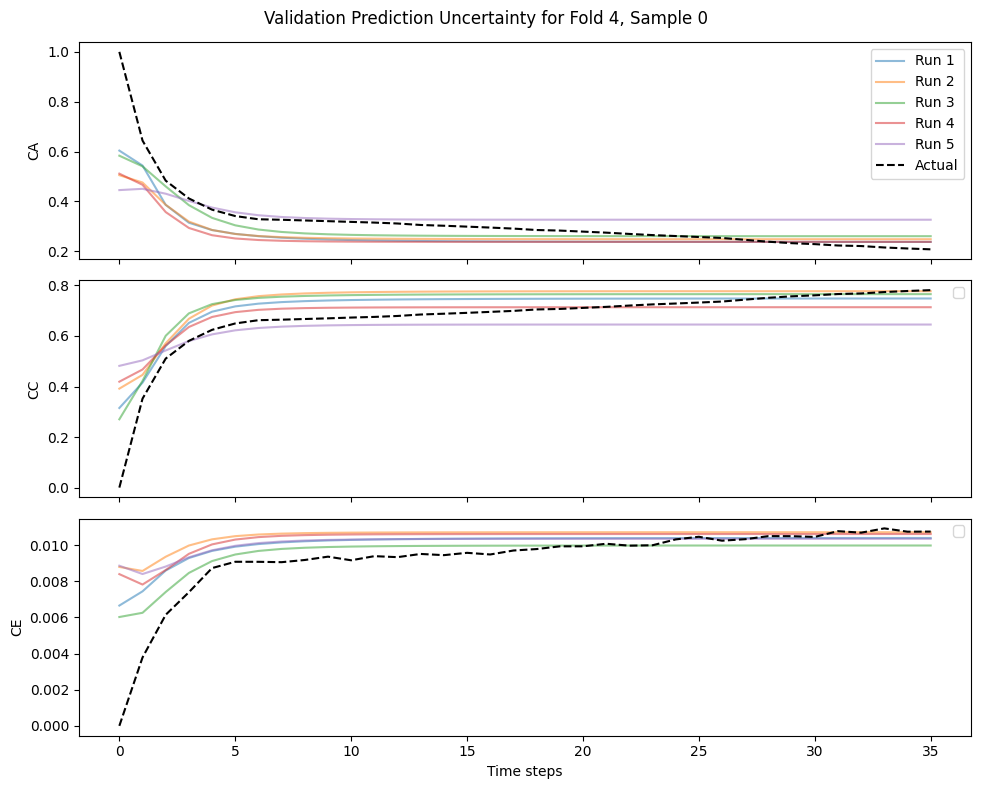

In [25]:
import matplotlib.pyplot as plt

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

time = np.arange(36)  # time steps

for i, label in enumerate(['CA', 'CC', 'CE']):
    for run in range(5):
        axs[i].plot(time, all_val_preds[fold_idx][run, sample_idx, :, i], alpha=0.5, label=f'Run {run+1}' if i==0 else None)

    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', label='Actual' if i==0 else None)
    axs[i].set_ylabel(label)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Time steps")
plt.suptitle(f"Validation Prediction Uncertainty for Fold {fold_idx+1}, Sample {sample_idx}")
plt.tight_layout()
plt.show()

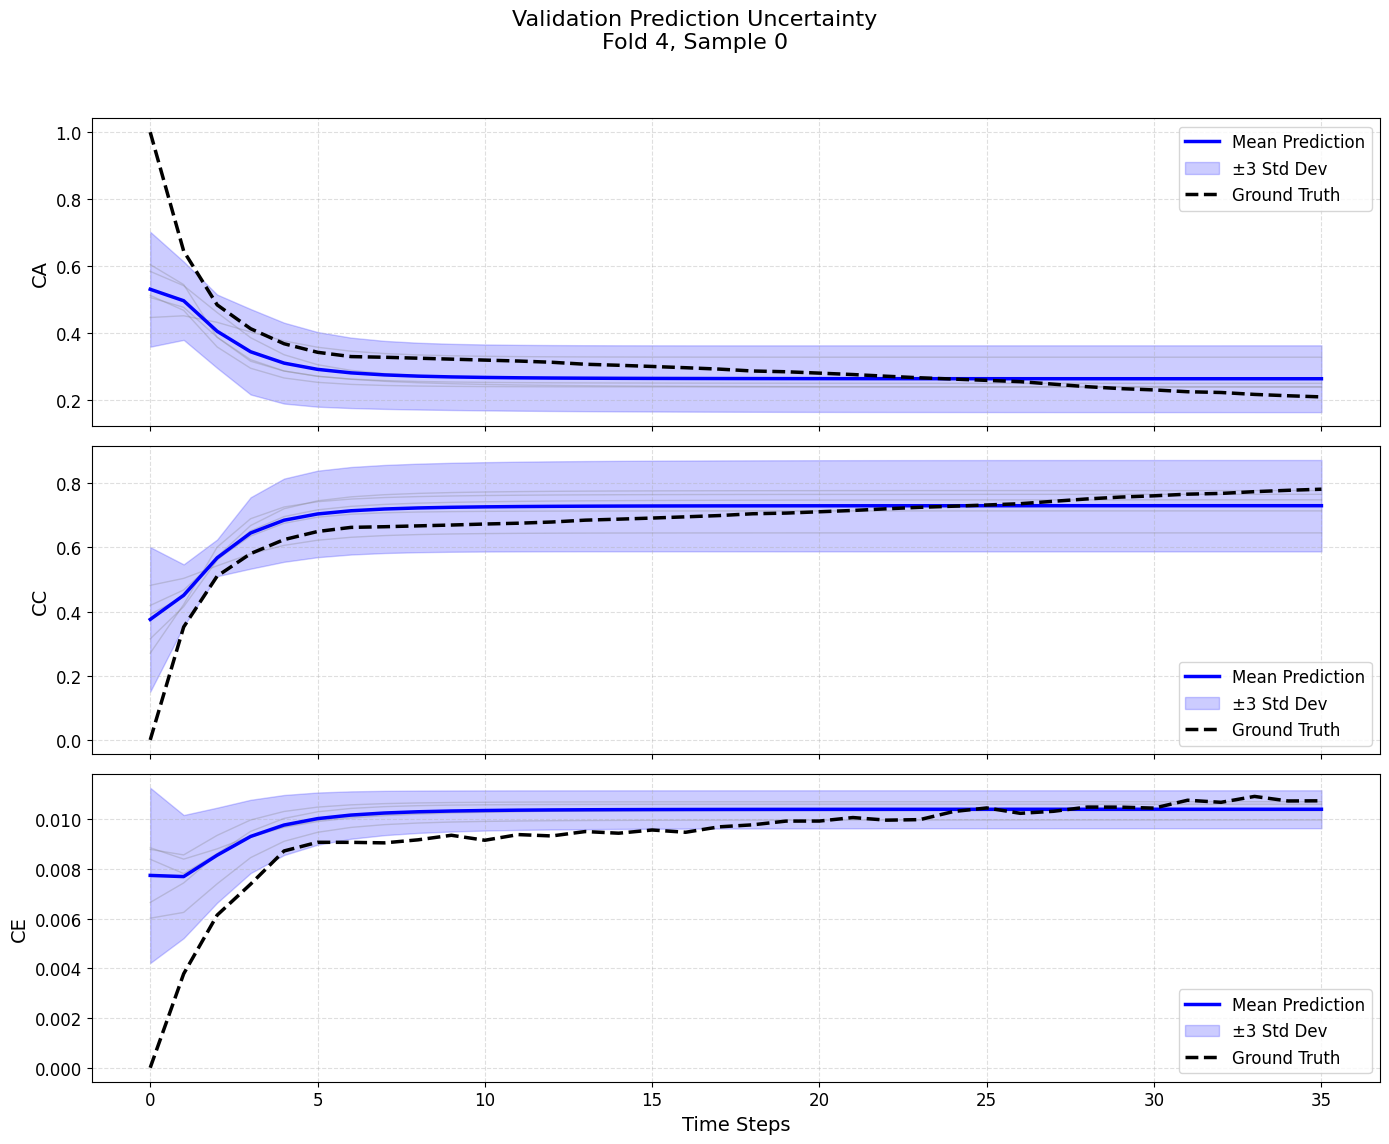

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set
time = np.arange(36)  # time steps
labels = ['CA', 'CC', 'CE']

n_runs = len(all_val_preds[fold_idx])

# Bigger figure and fonts
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, label in enumerate(labels):
    runs = np.array([all_val_preds[fold_idx][run, sample_idx, :, i] for run in range(n_runs)])
    mean_pred = runs.mean(axis=0)
    std_pred = runs.std(axis=0)

    # Light individual runs
    for run in range(n_runs):
        axs[i].plot(time, runs[run], color='gray', alpha=0.3, linewidth=1)

    # Mean and uncertainty
    axs[i].plot(time, mean_pred, color='blue', linewidth=2.5, label='Mean Prediction')
    axs[i].fill_between(time, mean_pred - 3*std_pred, mean_pred + 3*std_pred, 
                        color='blue', alpha=0.2, label='±3 Std Dev')

    # Ground truth
    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', linewidth=2.5, label='Ground Truth')

    axs[i].set_ylabel(label, fontsize=14)
    axs[i].legend(loc='best', fontsize=12)
    axs[i].tick_params(labelsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.4)

axs[-1].set_xlabel("Time Steps", fontsize=14)
plt.suptitle(f"Validation Prediction Uncertainty\nFold {fold_idx + 1}, Sample {sample_idx}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()